In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time

In [2]:
#Error
def _mean_squared_error(y, pred):
    return 0.5 * np.mean((y - pred) ** 2)

def _mean_abs_error(y, pred):
    return np.mean(np.abs(y, pred))

#activate function
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _fourier(x):
    return np.sin(x)

def _identity(x):
    return x

def _hardlimit(x):
    return (x >= 0).astype(int)

#Get function
def getActivation(name):
    return {
        'sigmoid': _sigmoid,
        'fourier': _fourier,
        'hardlimit': _hardlimit,
    }[name]

def getLoss(name):
    return {
        'mse': _mean_squared_error,
        'mae': _mean_abs_error
    }[name]

#T function
def T(x,L1,L2,cn):
    r = x - np.dot(L1,x) + L2
    s = np.abs(r)-cn
    s = np.maximum(s,0,s)
    return s*np.sign(r)

def thetan(x0,x1,n):
    if (x0==x1).all():
        return 0
    else:
        return 1/(2**n*np.linalg.norm(x1-x0,'fro'))

In [3]:
class ELM_AE:
    def __init__(self, n_hidden, X, activation='sigmoid',loss='mse'):
        self.X = X

        self._num_input_nodes = X.shape[1]
        self._num_output_units = X.shape[1]
        self._num_hidden_units = n_hidden
        
        self._activation = getActivation(activation)
        self._loss = getLoss(loss)
        
        self._beta = np.random.uniform(-1., 1., (self._num_hidden_units, self._num_output_units))
        self._w = np.random.uniform(-1., 1., (self._num_input_nodes, self._num_hidden_units))
        self._bias = np.zeros(shape=(self._num_hidden_units,))
        
        
    def fit(self, itrs, lam, display_time=False):
        H = self._activation(np.dot(self.X, self._w) + self._bias)

        if display_time:
            start = time.time()

        L = 1. / np.max(np.linalg.eigvals(np.dot(H.T, H))).real
        m = H.shape[1]
        n = self._num_output_units
        x0 = np.zeros((m,n))
        x1 = np.zeros((m,n))
        L1 = 2*L*np.dot(H.T, H)
        L2 = 2*L*np.dot(H.T, self.X)

        for i in range(1,itrs+1):
            cn = ((2e-6*i)/(2*i+1))*lam*L
            beta = 0.9*i/(i+1)
            alpha = 0.9*i/(i+1)

            y = x1 + thetan(x0,x1,i)*(x1-x0)
            z = (1-beta)*x1 + beta*T(x1,L1,L2,cn)

            Ty = T(y,L1,L2,cn)
            Tz = T(z,L1,L2,cn)
            x = (1-alpha)*Ty + alpha*Tz

            x0, x1 = x1, x

        if display_time:
            stop = time.time()
            print(f'Train time: {stop-start}')

        self._beta = x
        
    def __call__(self):
        H = self._activation( np.dot(self.X, self._w) + self._bias )
        return np.dot(H, self._beta)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
X = x_train #[:1000]
X = X.reshape((X.shape[0], 28 * 28))

In [7]:
model = ELM_AE(128, X)

In [8]:
model.fit(itrs=20, lam=1e-1, display_time=True)

C:\Users\ideapad 330\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Train time: 0.7883040904998779


In [9]:
result = model()

C:\Users\ideapad 330\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


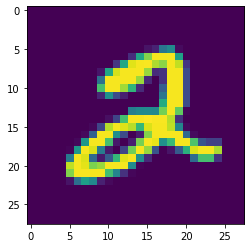

In [10]:
plt.imshow(X[5].reshape((28, 28)))

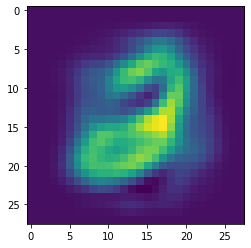

In [11]:
plt.imshow(result[5].reshape((28, 28)))

In [12]:
# images = []
# n = 6
# for x, r in zip(X[:n], result[:n]):
#     images.extend([x.reshape((28, 28)), r.reshape((28, 28))])
images_x = [x.reshape((28, 28)) for x in X[1:6]]
images_r = [r.reshape((28, 28)) for r in result[1:6]]
images = images_x + images_r

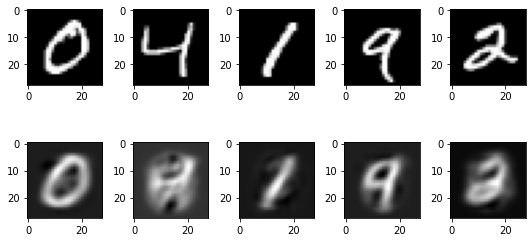

In [13]:
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    #ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()